# **2. CRSP**

### **0. Connect to WRDS**



In [149]:
import pandas as pd
import wrds
import numpy as np
import matplotlib.pyplot as plt

db = wrds.Connection(wrds_username='')

Loading library list...
Done


### **2.1. S&P500 portfolio**

First we can download the entire table.
We specify that 'start' and 'ending' columns are datetime type



In [150]:
sp500 = db.raw_sql("""
                        select *
                        from crsp.msp500list
                        """,
                        date_cols=['start', 'ending']) 
print(sp500)

      permno      start     ending
0      10006 1957-03-01 1984-07-18
1      10030 1957-03-01 1969-01-08
2      10049 1925-12-31 1932-10-01
3      10057 1957-03-01 1992-07-02
4      10078 1992-08-20 2010-01-28
...      ...        ...        ...
2042   93159 2012-07-31 2016-03-29
2043   93246 2021-03-22 2023-12-29
2044   93422 2010-07-01 2015-06-30
2045   93429 2017-03-01 2023-12-29
2046   93436 2020-12-21 2023-12-29

[2047 rows x 3 columns]


We can filter the resulting dataframe

In [151]:
filter_date = pd.to_datetime('2023-01-31')

# Filter the dataframe
filtered_df = sp500[(sp500['start'] <= filter_date) & (sp500['ending'] > filter_date)]

# Display the filtered dataframe
print(filtered_df)

      permno      start     ending
6      10104 1989-08-03 2023-12-29
7      10107 1994-06-07 2023-12-29
11     10138 1999-10-13 2023-12-29
12     10145 1925-12-31 2023-12-29
45     10516 1981-07-30 2023-12-29
...      ...        ...        ...
2040   93096 2012-12-03 2023-12-29
2041   93132 2018-10-11 2023-12-29
2043   93246 2021-03-22 2023-12-29
2045   93429 2017-03-01 2023-12-29
2046   93436 2020-12-21 2023-12-29

[503 rows x 3 columns]


Or we can introduce the filter in the SQL query to avoid downloading all the data

In [152]:
filter_date = pd.to_datetime('2023-01-31')

sp500 = db.raw_sql("""
                    select *
                    from crsp.msp500list as a
                    where a.start <= '%(date_start)s' and a.ending > '%(date_end)s'
                    """ % {'date_start': filter_date, 'date_end': filter_date},
                        date_cols=['start', 'ending'])
print(sp500)

     permno      start     ending
0     10104 1989-08-03 2023-12-29
1     10107 1994-06-07 2023-12-29
2     10138 1999-10-13 2023-12-29
3     10145 1925-12-31 2023-12-29
4     10516 1981-07-30 2023-12-29
..      ...        ...        ...
498   93096 2012-12-03 2023-12-29
499   93132 2018-10-11 2023-12-29
500   93246 2021-03-22 2023-12-29
501   93429 2017-03-01 2023-12-29
502   93436 2020-12-21 2023-12-29

[503 rows x 3 columns]


We merge the information about S&P500 membership with the monthly stock file

In [153]:
sp500 = db.raw_sql("""
                        SELECT a.*, b.date, b.ret, b.prc
                        FROM crsp.msp500list AS a,
                        crsp.msf AS b
                        WHERE a.permno=b.permno
                        AND b.date >= a.start AND b.date<= a.ending
                        AND b.date>='01/01/2000'
                        ORDER BY DATE;
                        """, date_cols=['start', 'ending', 'date'])
print(sp500)

        permno      start     ending       date       ret        prc
0        77178 1999-07-22 2023-12-29 2000-01-31 -0.278921  127.00000
1        48485 1976-07-01 2006-03-31 2000-01-31 -0.139194   58.75000
2        19502 1979-10-11 2023-12-29 2000-01-31 -0.044872   27.93750
3        28847 1986-12-18 2002-05-14 2000-01-31 -0.311891   22.06250
4        56573 1986-02-13 2023-12-29 2000-01-31 -0.134135   58.50000
...        ...        ...        ...        ...       ...        ...
144482   22111 1973-05-31 2023-12-29 2023-12-29  0.013449  156.74001
144483   44206 2009-03-17 2023-12-29 2023-12-29  0.050244   61.72000
144484   23473 1997-12-18 2023-12-29 2023-12-29  0.013815  103.46000
144485   77274 2004-07-01 2023-12-29 2023-12-29  0.067363   81.01000
144486   10138 1999-10-13 2023-12-29 2023-12-29  0.087686  107.69000

[144487 rows x 6 columns]


We then compute the equal weight returns

In [154]:
# Compute the equal weight average return per date
eq_weight_avg_df = sp500.groupby('date')['ret'].mean().reset_index(name='eq_weight_avg_ret')

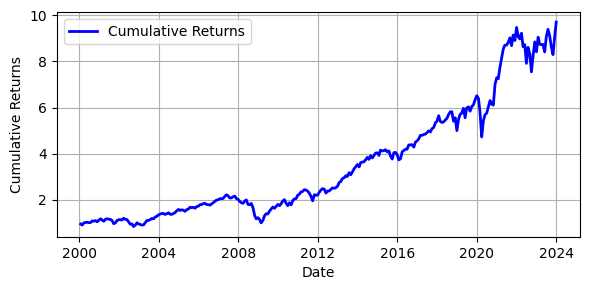

In [155]:
import matplotlib.pyplot as plt
# Calculate cumulative returns
eq_weight_avg_df['cumulative_ret'] = \
    (1 + eq_weight_avg_df['eq_weight_avg_ret']).cumprod() 

# Plot the cumulative returns
plt.figure(figsize=(6, 3))
plt.plot(eq_weight_avg_df['date'], eq_weight_avg_df['cumulative_ret'],
         label='Cumulative Returns', color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.legend()
plt.savefig("plot20.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

### **2.2. All US Stocks**

We apply several filters to narrow down the data:

- Use stock prices from NYSE, Amex, and NASDAQ.
- Focus on US-listed common stocks.

In [156]:
# Define the date range
start_date = '2010-01-01'
end_date = '2024-01-01'

# Query CRSP data
crsp_monthly_query = f"""
    SELECT msf.permno, msf.date, msf.ret,
            msf.shrout, msf.prc, mse.siccd
    FROM crsp.msf AS msf
    INNER JOIN crsp.msenames AS mse
        ON msf.permno = mse.permno
        AND mse.namedt <= msf.date
        AND msf.date <= mse.nameendt
    WHERE msf.date BETWEEN '{start_date}' AND '{end_date}'
        AND ( (mse.shrcd=10 ) OR (mse.shrcd=11 ) )
"""

crsp_monthly = db.raw_sql(crsp_monthly_query)
print(crsp_monthly.head())

   permno        date       ret   shrout    prc  siccd
0   10051  2020-10-30  0.104298  38101.0  17.47   4813
1   10051  2020-11-30  0.298798  38109.0  22.69   4813
2   10051  2020-12-31 -0.030851  38109.0  21.99   4813
3   10051  2021-01-29 -0.068213  38109.0  20.49   4813
4   10051  2021-02-26  0.072718  38109.0  21.98   4813


Preprocessing of price

In [157]:
crsp_monthly.prc = pd.to_numeric(crsp_monthly.prc, errors='coerce').fillna(np.nan).astype(float)
crsp_monthly.prc = abs(crsp_monthly.prc)
print(crsp_monthly.head())

   permno        date       ret   shrout    prc  siccd
0   10051  2020-10-30  0.104298  38101.0  17.47   4813
1   10051  2020-11-30  0.298798  38109.0  22.69   4813
2   10051  2020-12-31 -0.030851  38109.0  21.99   4813
3   10051  2021-01-29 -0.068213  38109.0  20.49   4813
4   10051  2021-02-26  0.072718  38109.0  21.98   4813



We also map SIC codes to industry names:

In [158]:
# Map SIC codes to industry names
def assign_industry(siccd):
    if 1 <= siccd <= 999: return "Agriculture"
    elif 1000 <= siccd <= 1499: return "Mining"
    elif 1500 <= siccd <= 1799: return "Construction"
    elif 2000 <= siccd <= 3999: return "Manufacturing"
    elif 4000 <= siccd <= 4899: return "Transportation"
    elif 4900 <= siccd <= 4999: return "Utilities"
    elif 5000 <= siccd <= 5199: return "Wholesale"
    elif 5200 <= siccd <= 5999: return "Retail"
    elif 6000 <= siccd <= 6799: return "Finance"
    elif 7000 <= siccd <= 8999: return "Services"
    elif 9000 <= siccd <= 9999: return "Public"
    else: return "Other"

crsp_monthly["industry"] = crsp_monthly["siccd"].apply(assign_industry)

In [159]:
crsp_monthly.industry.value_counts()

industry
Manufacturing     201028
Public            117876
Finance           108080
Services           94349
Retail             31747
Mining             26150
Transportation     25967
Wholesale          17952
Utilities          16715
Construction        7077
Other               1992
Agriculture         1458
Name: count, dtype: int64

Compute and Plot Cumulative Returns for Each Industry, Weighted by Market Capitalization

Cumulative returns for each industry are calculated by multiplying the monthly returns by market capitalization and then aggregating those values. Finally, we divide by the total market capitalization of the industry to get the cumulative return.

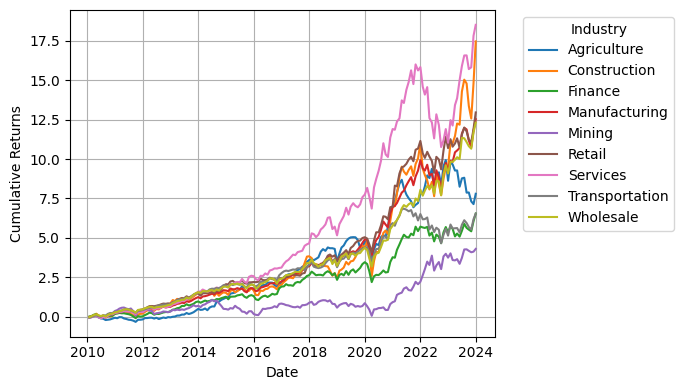

In [161]:
# Compute market capitalization in billions
crsp_monthly['mktcap'] = crsp_monthly['shrout'] * crsp_monthly['prc'] / 1_000_000_000  # in billions

# Calculate market-cap weighted returns
crsp_monthly['mktcap_weighted_ret'] = crsp_monthly['ret'] * crsp_monthly['mktcap']

# Group by industry and date to calculate cumulative returns weighted by market cap
cumulative_returns_by_industry = (crsp_monthly
    .groupby(['industry', 'date'])
    .agg({'mktcap_weighted_ret': 'sum', 'mktcap': 'sum'})
    .reset_index())

# Calculate weighted average return for each industry
cumulative_returns_by_industry['weighted_ret'] = (
    cumulative_returns_by_industry['mktcap_weighted_ret'] / cumulative_returns_by_industry['mktcap']
)

# Calculate cumulative returns for each industry
cumulative_returns_by_industry['cumulative_return'] = (
    cumulative_returns_by_industry
    .groupby('industry')['weighted_ret']
    .apply(lambda x: (1 + x).cumprod() - 1)
    .reset_index(drop=True)  # Ensure index is reset after the groupby operation
)

# Get the list of industries, excluding "Services", "Utilities", and "Public"
excluded_industries = ['Utilities', 'Public', 'Other']
industries = [industry for industry in cumulative_returns_by_industry['industry'].unique() if industry not in excluded_industries]

# Plot cumulative returns over time for all industries except excluded ones, since 2010
plt.figure(figsize=(7, 4))

for industry in industries:
    industry_data = cumulative_returns_by_industry[cumulative_returns_by_industry['industry'] == industry]
    plt.plot(industry_data['date'], industry_data['cumulative_return'], label=industry)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot21.pdf", format="pdf", bbox_inches="tight")
plt.show()
